# Astro 8030 Final
## Mary Kaldor
## December 13, 2024

### Problem 1
#### Create a computer model that solves the structure of a star assuming a set of central boundary conditions. Specifically, solve a star of mass $M=7.08M_{sun}$, with solar composition: X=0.7, Y=0.28. Use the following central boundary conditions (cgs units):

#### $logP_c = 16.668$
#### $logT_c = 7.46$

#### Integrate the equations of stellar structure outwards from m=0 to the surface (or to where the density, temperature or pressure become negative if that happens before you reach the surface) using the appropriate microphysics. Specifically, assume that:

#### • Equation of state is given by the sum of radiation + ideal gas and fully ionized gas.
#### • Energy generation is a combination of the pp chain, CNO cycle, and triple-alpha process.
#### • Opacity is given by: 
#### - Undergrads -- a combination of electron scattering, free-free, boundfree, and H- and use the analytic approximations for these.
#### - Grads -- interpolating in the OPAL opacity tables and using the analytic approximations where the tables do not apply.

#### Hand in the following:
#### a. A copy of your code (printed, ipynb, etc. Ask me if uncertain what constitutes a copy of your code)
#### b. The following 8 figures, where m is in solar units:
#### - Pressure: $logP$ vs. m (P in cgs units)
#### - Temperature: $logT$ vs. m (T in Kelvin)
#### - Density: $log\rho$ vs. m ($\rho$ in cgs units)
#### - Radius: r vs. m (r in solar radii)
#### - Luminosity: $L_m$ vs. m ($L_m$ in solar luminosities)
#### - Opacity: $\kappa$ vs. m ($\kappa$ in cgs units)
#### - Energy generation rate: $\varepsilon$ vs. m ($\varepsilon$ in cgs units)
#### - Ratio of radiative to adiabatic gradient vs. m (this is >1 in convective regions)
#### c. The values for the final radius and luminosity of the star (in solar units)
#### d. A list of the main assumptions you made in this calculation and the main things a more accurate model would have to include.

# a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
import astropy.units as u
import astropy.constants as const

In [2]:
G = const.G.cgs.value
k_B = const.k_B.cgs.value
c = const.c.cgs.value
e = const.e.value
h = const.h.cgs.value
hbar = const.hbar.cgs.value
m_e = const.m_e.cgs.value
m_p = const.m_p.cgs.value
m_n = const.m_n.cgs.value
M_sun = const.M_sun.cgs.value
R_sun = const.R_sun.cgs.value
L_sun = const.L_sun.cgs.value
N_A = const.N_A.cgs.value
a = 7.56e-15
sigma = const.sigma_sb.cgs.value

In [3]:
X = 0.7
Y = 0.28
Z = 0.02
M= 7.08*M_sun
logPc = 16.668
logTc = 7.46
Pc = 10**logPc
Tc = 10**logTc

In [4]:
mu = (X/1 + 1*X*1/1 + Y/4 + 2*Y*1/4 + 0 + Z*1/2)**-1

In [5]:
def rho_function(P, T):
    rho = ((P-(a*(T**4))/3)*mu)/(N_A*k_B*T)
    return rho

In [6]:
def Rfunc_to_rho(Rfunc, T):
    rho = Rfunc*((T/1e6)**3)
    return rho

def rho_to_Rfunc(rho, T):
    Rfunc = rho/((T/1e6)**3)
    return Rfunc

In [7]:
def kappa_function(P, R, T):
    kh = 2.5e-31*(0.02/0.02)*((rho_function(P, T))**(1/2))*(T**9)
    ke = 0.2*(1+0.7)
    kff = 4e22*(0.7+0.28)*(1+0.7)*(rho_function(P, T))*(T**(-3.5))
    kbf = 4e25*(0.02)*(1+0.7)*(rho_function(P, T))*(T**(-3.5))
    ktot = ((kh**(-1))+((ke+kff+kbf)**(-1)))**(-1)
    return ktot

In [8]:
def epsilon_function(P, R, T, X, Y, Z):
    rho = rho_function(P, T)
    epp = (2.4e4*rho*(X**2)*(np.e**(-3.38/((T/1e9)**(1/3)))))/((T/1e9)**(2/3))
    ecno = (4.4e25*rho*X*Z*(np.e**(-15.228/((T/1e9)**(1/3)))))/((T/1e9)**(2/3))
    e3a = (5e8*(rho**2)*(Y**3)*(np.e**(-4.4/(T/1e9))))/((T/1e9)**3)
    epsilon = epp + ecno + e3a
    return epsilon

In [9]:
def gamma_function(P, R, T):
    rho = rho_function(P, T)
    beta = (N_A*k_B*rho*T)/(mu*P)
    gamma = (32-(24*beta)-(3*(beta**2)))/(24-(18*beta)-(3*(beta**2)))
    return gamma

In [10]:
opacity = np.genfromtxt("./opacity_table.dat")
logt = opacity[1:,0]
logr = opacity[0,1:]
opacity_values = opacity[1:, 1:]

In [11]:
interpolator = scipy.interpolate.RegularGridInterpolator((logt, logr), opacity_values)
def interpolate_kappa(rho, T, P, R):
    Rfunc = rho_to_Rfunc(rho, T)
    Rlog = np.log10(Rfunc)
    Tlog = np.log10(T)
    if (Rlog>np.max(logr) or Rlog<np.min(logr) or Tlog>np.max(logt) or Tlog<np.min(logt)):
        kappa = kappa_function(P, R, T)
    else:
        kappa = interpolator(np.array([Tlog, Rlog]).T)
        kappa = 10**kappa[0]
    return kappa

In [12]:
def r_function(rold, Pold, Told, dm, backwards=False):
    if backwards:
        drdm = -1/(4*np.pi*(rold**2)*rho_function(Pold, Told))
    if not backwards:
        drdm = 1/(4*np.pi*(rold**2)*rho_function(Pold, Told))
    rnew = rold + (drdm*dm)
    return rnew

In [13]:
def P_function(rold, Pold, m, dm, backwards=False):
    if backwards:
        dPdm = (G*m)/(4*np.pi*(rold**4))
    if not backwards:
        dPdm = (-G*m)/(4*np.pi*(rold**4))
    Pnew = Pold + (dPdm*dm)
    return Pnew

In [14]:
def L_function(rold, Pold, Lold, Told, dm, backwards=False):
    if backwards:
        dLdm = -1*(epsilon_function(Pold, rold, Told, X, Y, Z))
    if not backwards:
        dLdm = epsilon_function(Pold, rold, Told, X, Y, Z)
    Lnew = Lold + (dLdm*dm)
    return Lnew, dLdm

In [15]:
def T_function(rold, Pold, Lold, Told, m, dm, backwards=False):
    condition = ((16*np.pi*a*c*G*(Told**4)*m)*(1-(1/gamma_function(Pold, rold, Told))))/(3*interpolate_kappa(rho_function(Pold, Told), Told, Pold, rold)*Pold)
    Tratio = Lold/condition
    if Tratio > 1:
        rad = False
        conv = True
    else:
        conv = False
        rad = True

    if backwards:
        if rad:
            dTdm = ((3*interpolate_kappa(rho_function(Pold, Told), Told, Pold, rold)*Lold)/(64*(np.pi**2)*a*c*(rold**4)*(Told**3)))
        if conv:
            dTdm = (((1-(1/gamma_function(Pold, rold, Told)))*(G*m*Told))/(4*np.pi*(rold**4)*Pold))

    if not backwards:
        if rad:
            dTdm = -1*((3*interpolate_kappa(rho_function(Pold, Told), Told, Pold, rold)*Lold)/(64*(np.pi**2)*a*c*(rold**4)*(Told**3)))
        if conv:
            dTdm = -1*(((1-(1/gamma_function(Pold, rold, Told)))*(G*m*Told))/(4*np.pi*(rold**4)*Pold))

    Tkappa = interpolate_kappa(rho_function(Pold, Told), Told, Pold, rold)
    Tnew = Told + (dTdm*dm)
    return Tnew, Tratio, Tkappa

In [16]:
log_masses = np.linspace(1e-4*np.log10(M), np.log10(M), 10000)
masses = 10**log_masses
mc = masses[0]
rc = ((3*mc)/(4*np.pi*rho_function(Pc, Tc)))**(1/3)
Lc = epsilon_function(Pc, rc, Tc, X, Y, Z)*mc
conditionc = ((16*np.pi*a*c*G*(Tc**4)*mc)*(1-(1/gamma_function(Pc, rc, Tc))))/(3*interpolate_kappa(rho_function(Pc, Tc), Tc, Pc, rc)*Pc)
Tratioc = Lc/conditionc
rhoc = rho_function(Pc, Tc)
Lepsilonc = epsilon_function(Pc, rc, Tc, X, Y, Z)
Tkappac = interpolate_kappa(rho_function(Pc, Tc), Tc, Pc, rc)

In [17]:
print(rc, Pc, Lc, Tc, mc)
print(gamma_function(Pc, rc, Tc))
print(T_function(rc, Pc, Lc, Tc, mc, masses[0], False))
print(rho_function(Pc, Tc))

0.27526440166786037 4.6558609352295816e+16 20734.215907553513 28840315.031266056 1.0078939862262581
1.5712365356600237
(28840315.031266056, 5.598914918629067, 0.37265103825587403)
11.536553749560527


In [18]:
def new_values(rold, Pold, Lold, Told, i):
    m = masses[i]
    if i>=1:
        dm = masses[i]-masses[i-1]
    else:
        dm = masses[i]
    rnew = r_function(rold, Pold, Told, dm, False)
    Pnew = P_function(rold, Pold, m, dm, False)
    Lnew, Lepsilonnew = L_function(rold, Pold, Lold, Told, dm, False)
    Tnew, Trationew, Tkappa = T_function(rold, Pold, Lold, Told, m, dm, False)
    rhonew = rho_function(Pold, Told)
    return rnew, Pnew, Lnew, Lepsilonnew, Tnew, Trationew, Tkappa, rhonew, m, dm

In [19]:
ri, Pi, Li, Ti, Tratioi, rhoi = rc, Pc, Lc, Tc, Tratioc, rhoc
rlist = []
Plist = []
Llist = []
Lepsilonlist = []
Tlist = []
Tratiolist = []
Tkappalist = []
rholist = []
mlist = []
dmlist = []

rlist.append(rc)
Plist.append(Pc)
Llist.append(Lc)
Lepsilonlist.append(Lepsilonc)
Tlist.append(Tc)
Tratiolist.append(Tratioc)
Tkappalist.append(Tkappac)
rholist.append(rhoc)
mlist.append(mc)
dmlist.append(mc)

for i in range(0, len(masses)):
    if (Pi<0 or Ti<0):
        break
    ri, Pi, Li, Lepsilon, Ti, Tratioi, Tkappa, rhoi, mi, dmi = new_values(ri, Pi, Li, Ti, i)
    rlist.append(ri)
    Plist.append(Pi)
    Llist.append(Li)
    Lepsilonlist.append(Lepsilon)
    Tlist.append(Ti)
    Tratiolist.append(Tratioi)
    Tkappalist.append(Tkappa)
    rholist.append(rhoi)
    mlist.append(mi)
    dmlist.append(dmi)

In [20]:
mlist = mlist/M_sun
Llist = Llist/L_sun
rlist = rlist/R_sun

# b)

/tmp/ipykernel_29488/3379462368.py:7: RuntimeWarning: invalid value encountered in log10
  ax[0,1].plot(mlist, np.log10(Plist), color="magenta")


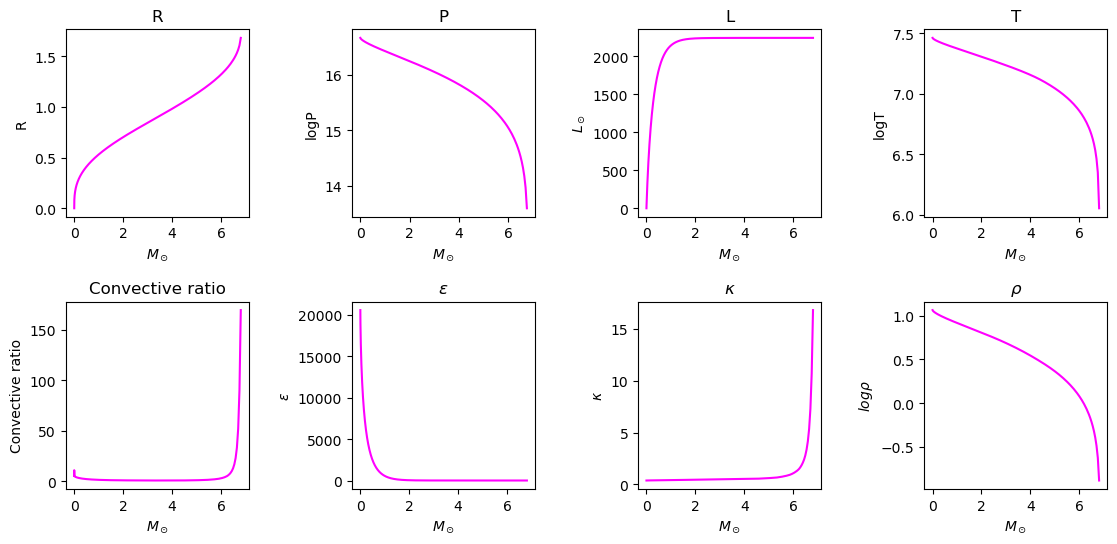

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
fig.tight_layout(pad=4)
ax[0,0].plot(mlist, rlist, color="magenta")
ax[0,0].set_xlabel(r"$M_\odot$")
ax[0,0].set_ylabel("R")
ax[0,0].set_title("R")
ax[0,1].plot(mlist, np.log10(Plist), color="magenta")
ax[0,1].set_xlabel(r"$M_\odot$")
ax[0,1].set_ylabel("logP")
ax[0,1].set_title("P")
ax[1,1].plot(mlist, Lepsilonlist, color="magenta")
ax[1,1].set_xlabel(r"$M_\odot$")
ax[1,1].set_ylabel(r"$\varepsilon$")
ax[1,1].set_title(r"$\varepsilon$")
ax[0,2].plot(mlist, Llist, color="magenta")
ax[0,2].set_xlabel(r"$M_\odot$")
ax[0,2].set_ylabel(r"$L_\odot$")
ax[0,2].set_title("L")
ax[1,2].plot(mlist, Tkappalist, color="magenta")
ax[1,2].set_xlabel(r"$M_\odot$")
ax[1,2].set_ylabel(r"$\kappa$")
ax[1,2].set_title(r"$\kappa$")
ax[0,3].plot(mlist, np.log10(Tlist), color="magenta")
ax[0,3].set_xlabel(r"$M_\odot$")
ax[0,3].set_ylabel("logT")
ax[0,3].set_title("T")
ax[1,0].plot(mlist, Tratiolist, color="magenta")
ax[1,0].set_xlabel(r"$M_\odot$")
ax[1,0].set_ylabel("Convective ratio")
ax[1,0].set_title("Convective ratio")
ax[1,3].plot(mlist, np.log10(rholist), color="magenta")
ax[1,3].set_xlabel(r"$M_\odot$")
ax[1,3].set_ylabel(r"$log\rho$")
ax[1,3].set_title(r"$\rho$")
plt.show()

In [22]:
rfinal = rlist[-1]
Lfinal = Llist[-1]
rfinal, Lfinal

(1.6807511882314339, 2239.2505274032214)

# c)
### The final radius is equal to 1.68 $M_\odot$ and the final luminosity is equal to 2239.25 $L_\odot$!

# d)
#### The assumptions that I made in this model is that everything in this star is ionized, and a better model would include ionization fractions in its math. I also assumed that the only methods of energy transport were convection OR radiation (and never a combination of them). A better model would probably incorporate both at the same time and other manners of energy transport (like conduction or neutrino radiation). Similarly, this model assumes only 3 kinds of energy generation (pp, triple alpha, and CNO) when there might be other mechanisms. We are under the current assumption that pressure is only due to radiation and gas, and a better stellar model would note that there could be degenerate pressure from degenerate matter (we also assume that there is only non-degenerate matter). We simplify our model a lot by assuming a static model in hydrostatic equilibrium, when it reality stars could be doing a lot of stuff! We don't factor in pulsation or rotation (which would in turn affect our assumption of spherical symmetry -- a rotating star would be oblate). In general, a better model would not start by assuming we know what's going on in the center of the star and there would be addition GR or magnetic effects.

### Part 2 (for graduate students or very ambitious undergrads)
#### Generalize your model so that it does not need to know the exact central boundary conditions. Run the model on a star of mass $M=2.82M_{sun}$ with composition: X=0.7, Y=0.28. Hand in your code, produce the same plots as in part 1, and list the final values of central temperature, central pressure, total radius, and total luminosity.

In [23]:
M_part2 = 2.82*M_sun
log_masses_part2 = np.linspace(1e-4*np.log10(M_part2), np.log10(M_part2), 10000)
masses_part2 = 10**log_masses_part2

In [24]:
half_idx = np.where(masses_part2>(M_part2/2))[0][0]
inner_masses = masses_part2[:half_idx]
outer_masses = masses_part2[half_idx:]
outer_masses = np.flip(outer_masses)

In [25]:
def new_values_part2(rold, Pold, Lold, Told, i, backwards, masses):
    m = masses[i]
    if backwards:
        if i>=1:
            dm = masses[i-1]-masses[i]
        else:
            dm = -1*(masses[i+1]-masses[i])
    if not backwards:
        if i>=1:
            dm = masses[i]-masses[i-1]
        else:
            dm = masses[i]

    rnew_part2 = r_function(rold, Pold, Told, dm, backwards)
    Pnew_part2 = P_function(rold, Pold, m, dm, backwards)
    Lnew_part2, Lepsilonnew_part2 = L_function(rold, Pold, Lold, Told, dm, backwards)
    Tnew_part2, Trationew_part2, Tkappa_part2 = T_function(rold, Pold, Lold, Told, m, dm, backwards)
    rhonew_part2 = rho_function(Pold, Told)
    return rnew_part2, Pnew_part2, Lnew_part2, Lepsilonnew_part2, Tnew_part2, Trationew_part2, Tkappa_part2, rhonew_part2, m, dm

In [26]:
#ri_part2, Pi_part2, Li_part2, Ti_part2, Tratioi_part2, rhoi_part2 = rc,_part2 Pc_part2, Lc_part2, Tc_part2, Tratioc_part2, rhoc_part2
rlist_part2_inner = []
Plist_part2_inner = []
Llist_part2_inner = []
Lepsilonlist_part2_inner = []
Tlist_part2_inner = []
Tratiolist_part2_inner = []
Tkappalist_part2_inner = []
rholist_part2_inner = []
mlist_part2_inner = []
dmlist_part2_inner = []

Pi_part2_inner = 1.46e+17
Ti_part2_inner = 2.4265342e7
mc_part2_inner = inner_masses[0]
ri_part2_inner = ((3*mc_part2_inner)/(4*np.pi*rho_function(Pi_part2_inner, Ti_part2_inner)))**(1/3)
Li_part2_inner = epsilon_function(Pi_part2_inner, ri_part2_inner, Ti_part2_inner, X, Y, Z)*mc_part2_inner
rhoi_part2_inner = rho_function(Pi_part2_inner, Ti_part2_inner)

for i in range(0, len(inner_masses)):
    if (Pi_part2_inner<0 or Ti_part2_inner<0 or rhoi_part2_inner<0):
        break
    ri_part2_inner, Pi_part2_inner, Li_part2_inner, Lepsilon_part2_inner, Ti_part2_inner, Tratioi_part2_inner, Tkappa_part2_inner, rhoi_part2_inner, mi_part2_inner, dmi_part2_inner = new_values_part2(ri_part2_inner, Pi_part2_inner, Li_part2_inner, Ti_part2_inner, i, False, inner_masses)
    rlist_part2_inner.append(ri_part2_inner)
    Plist_part2_inner.append(Pi_part2_inner)
    Llist_part2_inner.append(Li_part2_inner)
    Lepsilonlist_part2_inner.append(Lepsilon_part2_inner)
    Tlist_part2_inner.append(Ti_part2_inner)
    Tratiolist_part2_inner.append(Tratioi_part2_inner)
    Tkappalist_part2_inner.append(Tkappa_part2_inner)
    rholist_part2_inner.append(rhoi_part2_inner)
    mlist_part2_inner.append(mi_part2_inner)
    dmlist_part2_inner.append(dmi_part2_inner)

In [27]:
rlist_part2_outer = []
Plist_part2_outer = []
Llist_part2_outer = []
Lepsilonlist_part2_outer = []
Tlist_part2_outer = []
Tratiolist_part2_outer = []
Tkappalist_part2_outer = []
rholist_part2_outer = []
mlist_part2_outer = []
dmlist_part2_outer = []

ri_part2_outer = 4.49e10
Li_part2_outer = 6.58e+35
Ti_part2_outer = (Li_part2_outer/(4*np.pi*(ri_part2_outer**2)))**(1/4)
Pi_part2_outer = ((a*(Ti_part2_outer**4))/3) + ((N_A*k_B*Ti_part2_outer)/mu)
rhoi_part2_outer = rho_function(Pi_part2_outer, Ti_part2_outer)

for i in range(0, len(outer_masses)):
    if (Pi_part2_outer<0 or Ti_part2_outer<0 or rhoi_part2_outer<0):
        break
    ri_part2_outer, Pi_part2_outer, Li_part2_outer, Lepsilon_part2_outer, Ti_part2_outer, Tratioi_part2_outer, Tkappa_part2_outer, rhoi_part2_outer, mi_part2_outer, dmi_part2_outer = new_values_part2(ri_part2_outer, Pi_part2_outer, Li_part2_outer, Ti_part2_outer, i, True, outer_masses)
    rlist_part2_outer.append(ri_part2_outer)
    Plist_part2_outer.append(Pi_part2_outer)
    Llist_part2_outer.append(Li_part2_outer)
    Lepsilonlist_part2_outer.append(Lepsilon_part2_outer)
    Tlist_part2_outer.append(Ti_part2_outer)
    Tratiolist_part2_outer.append(Tratioi_part2_outer)
    Tkappalist_part2_outer.append(Tkappa_part2_outer)
    rholist_part2_outer.append(rhoi_part2_outer)
    mlist_part2_outer.append(mi_part2_outer)
    dmlist_part2_outer.append(dmi_part2_outer)

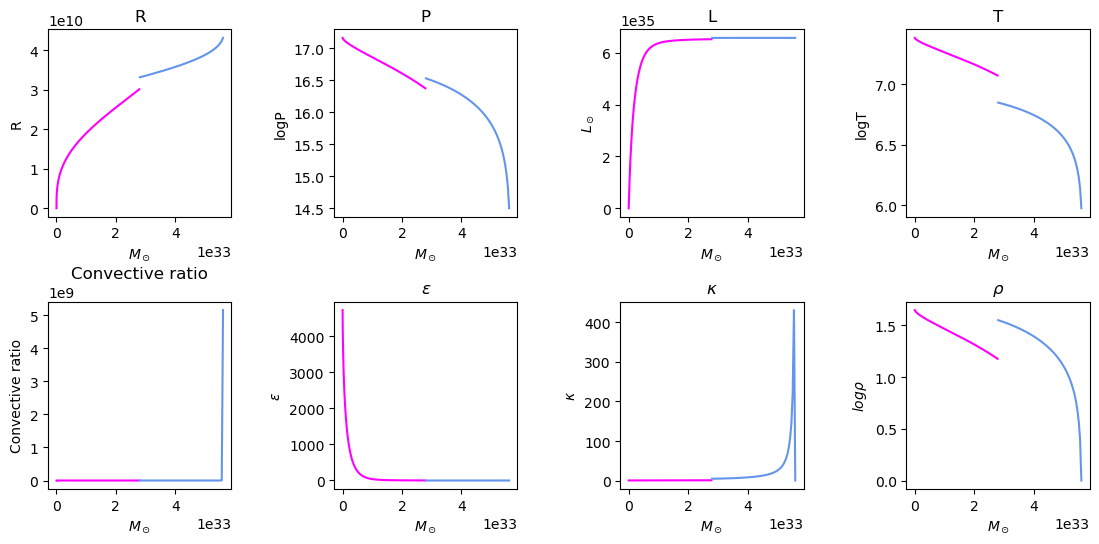

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
fig.tight_layout(pad=4)
ax[0,0].plot(mlist_part2_inner, rlist_part2_inner, color="magenta")
ax[0,0].plot(mlist_part2_outer, rlist_part2_outer, color="cornflowerblue")
ax[0,0].set_xlabel(r"$M_\odot$")
ax[0,0].set_ylabel("R")
ax[0,0].set_title("R")
ax[0,1].plot(mlist_part2_inner, np.log10(Plist_part2_inner), color="magenta")
ax[0,1].plot(mlist_part2_outer, np.log10(Plist_part2_outer), color="cornflowerblue")
ax[0,1].set_xlabel(r"$M_\odot$")
ax[0,1].set_ylabel("logP")
ax[0,1].set_title("P")
ax[1,1].plot(mlist_part2_inner, Lepsilonlist_part2_inner, color="magenta")
ax[1,1].plot(mlist_part2_outer, Lepsilonlist_part2_outer, color="cornflowerblue")
ax[1,1].set_xlabel(r"$M_\odot$")
ax[1,1].set_ylabel(r"$\varepsilon$")
ax[1,1].set_title(r"$\varepsilon$")
ax[0,2].plot(mlist_part2_inner, Llist_part2_inner, color="magenta")
ax[0,2].plot(mlist_part2_outer, Llist_part2_outer, color="cornflowerblue")
ax[0,2].set_xlabel(r"$M_\odot$")
ax[0,2].set_ylabel(r"$L_\odot$")
ax[0,2].set_title("L")
ax[1,2].plot(mlist_part2_inner, Tkappalist_part2_inner, color="magenta")
ax[1,2].plot(mlist_part2_outer, Tkappalist_part2_outer, color="cornflowerblue")
ax[1,2].set_xlabel(r"$M_\odot$")
ax[1,2].set_ylabel(r"$\kappa$")
ax[1,2].set_title(r"$\kappa$")
ax[0,3].plot(mlist_part2_inner, np.log10(Tlist_part2_inner), color="magenta")
ax[0,3].plot(mlist_part2_outer, np.log10(Tlist_part2_outer), color="cornflowerblue")
ax[0,3].set_xlabel(r"$M_\odot$")
ax[0,3].set_ylabel("logT")
ax[0,3].set_title("T")
ax[1,0].plot(mlist_part2_inner, Tratiolist_part2_inner, color="magenta")
ax[1,0].plot(mlist_part2_outer, Tratiolist_part2_outer, color="cornflowerblue")
ax[1,0].set_xlabel(r"$M_\odot$")
ax[1,0].set_ylabel("Convective ratio")
ax[1,0].set_title("Convective ratio")
ax[1,3].plot(mlist_part2_inner, np.log10(rholist_part2_inner), color="magenta")
ax[1,3].plot(mlist_part2_outer, np.log10(rholist_part2_outer), color="cornflowerblue")
ax[1,3].set_xlabel(r"$M_\odot$")
ax[1,3].set_ylabel(r"$log\rho$")
ax[1,3].set_title(r"$\rho$")
plt.show()

In [29]:
r_disc = abs(np.log10(rlist_part2_inner[-1])-np.log10(rlist_part2_outer[-1]))
P_disc = abs(np.log10(Plist_part2_inner[-1])-np.log10(Plist_part2_outer[-1]))
L_disc = abs(np.log10(Llist_part2_inner[-1])-np.log10(Llist_part2_outer[-1]))
T_disc = abs(np.log10(Tlist_part2_inner[-1])-np.log10(Tlist_part2_outer[-1]))
r_disc, P_disc, L_disc, T_disc

(0.04198853420495752,
 0.15468371566234396,
 0.0033601652120012204,
 0.2243145034519678)

In [30]:
rlist_part2_outer[0]/R_sun, Plist_part2_outer[0], Llist_part2_outer[0]/L_sun, Tlist_part2_outer[0]

(0.6207657856354948, 318363033505162.6, 171.89132706374085, 946793.3194311679)

## This is about as far as I can go :)
### I took initial guesses from Brayan (who wrote a function) and then did some guessing by hand to see if I "turn the knobs" how my discrepancies compared to my previous iteration change. I got pretty close! My star seems too small for a 2.82 $M_\odot$ star, most likely.

## R = $0.620 R_\odot$
## P = $3.183*10^{14} dyne/cm^2$
## L = $171.891 L_\odot$
## T = $9.467*10^5 K$